<a href="https://colab.research.google.com/github/pedrocostanunes/Machine_Learning-Previsao_Inadimplencia/blob/main/Python/Modelo_Previsao_Inadimplencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center"> <img src="https://i.imgur.com/2eJkuJT.png" width="500px" /> </div>

## Introdução



Bem-vinde! 

Este projeto tem como objetivo construir um modelo de machine learning que pode predizer, com base em dados bancários de clientes da empresa Finance Cash (empresa fictícia), se um determinado cliente pode ou não se tornar inadimplente. 

Neste notebook, vamos explorar e analisar os dados, além de realizar a limpeza e a preparação desses dados para utilização em modelos de machine learning. Também vamos testar diferentes algoritmos de aprendizado de máquina e escolher o melhor modelo para ser usado na previsão de inadimplência.

Por fim, vamos exportar o modelo escolhido para ser usado em um dashboard no Power BI, onde será possível visualizar as informações de forma mais clara e intuitiva para steakholders e diretoria da empresa.

### Importando os dados

In [1]:
import pandas as pd

In [2]:
dados = pd.read_csv('/content/analise_risco_dados.csv', sep =';')

In [3]:
dados

,person_age,person_income,person_emp_length,person_home_ownership,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,33,48000,17.0,Rent,Debtconsolidation,B,3500,11.86,0,0.07,N,10
1,22,51000,6.0,Rent,Personal,A,7500,5.99,0,0.15,N,2
2,23,85000,2.0,Rent,Medical,B,9600,10.99,0,0.11,N,4
3,27,50000,5.0,Rent,Venture,B,12000,10.37,0,0.24,N,9
4,22,60000,0.0,Rent,Education,A,6025,0.00,0,0.10,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
34496,23,80500,5.0,Rent,Venture,B,7200,9.25,0,0.09,N,3
34497,39,56000,14.0,Mortgage,Personal,C,10000,12.73,0,0.18,Y,12
34498,28,29000,1.0,Rent,Medical,C,8000,13.11,1,0.28,Y,9
34499,27,44000,2.0,Mortgage,Medical,NaN,7500,10.59,0,0.14,N,3


### Traduzindo o nome das colunas

 Vamos criar um dicionário para traduzir o nome das colunas para o português e facilitar as análises.

In [4]:
dicionario = {
    'person_age': 'idade',
    'person_income': 'salario',
    'person_home_ownership': 'situacao_moradia',
    'person_emp_length': 'tempo_trabalho',
    'loan_intent': 'motivo_emprestimo',
    'loan_grade': 'pontuacao_emprestimo',
    'loan_amnt': 'valor_emprestimo',
    'loan_int_rate': 'taxa_juros',
    'loan_status': 'inadimplencia',
    'loan_percent_income': 'renda_percentual_emprestimo',
    'cb_person_default_on_file': 'devendo',
    'cb_person_cred_hist_length': 'tempo_de_credito'
}

dados.rename(dicionario, axis = 1, inplace = True)

In [5]:
dados.columns

Index(['idade', 'salario', 'tempo_trabalho', 'situacao_moradia',
       'motivo_emprestimo', 'pontuacao_emprestimo', 'valor_emprestimo',
       'taxa_juros', 'inadimplencia', 'renda_percentual_emprestimo', 'devendo',
       'tempo_de_credito'],
      dtype='object')

## Análise dos dados

Valores inconsistentes, outliers e dados nulos podem prejudicar o modelo de machine learning. Vamos indentificá-los.

##### a) Identificando dados nulos e dtypes

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34501 entries, 0 to 34500
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        34501 non-null  int64  
 1   salario                      34501 non-null  int64  
 2   tempo_trabalho               34501 non-null  float64
 3   situacao_moradia             34170 non-null  object 
 4   motivo_emprestimo            34186 non-null  object 
 5   pontuacao_emprestimo         34188 non-null  object 
 6   valor_emprestimo             34501 non-null  int64  
 7   taxa_juros                   34501 non-null  float64
 8   inadimplencia                34501 non-null  int64  
 9   renda_percentual_emprestimo  34501 non-null  float64
 10  devendo                      34131 non-null  object 
 11  tempo_de_credito             34501 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


* O dataset possui 34501 registros e um total de 11 colunas.
* Existem dados nulos em todas as 11 colunas. Serão tratados posteriormente.
* As variáveis `situacao_moradia`, `motivo_emprestimo`, `pontuacao_emprestimo` e `devendo` apresentam o dtype object e serão tratados.

---

##### b) Identificando outliers

Vamos analisar as variáveis numéricas para identificar outliers e ter uma primeira visão geral das distribuições dos dados.

In [7]:
dados.describe()

,idade,salario,tempo_trabalho,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,tempo_de_credito
count,34501.000000,3.450100e+04,34501.000000,34501.000000,34501.000000,34501.000000,34501.000000,34501.000000
mean,27.470595,6.537990e+04,4.613229,9498.565259,9.854838,0.216023,0.168653,5.807513
std,6.858473,6.144876e+04,4.159219,6359.131712,4.562927,0.411536,0.107530,4.063477
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,3.800000e+04,2.000000,5000.000000,7.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.590000,0.000000,0.150000,4.000000
75%,30.000000,7.875000e+04,7.000000,12000.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


* Existem valores discrepantes para as variáveis `idade` e `tempo_trabalho`.

* **Idade máxima** de 144 anos e **tempo de trabalho** de 123 anos são dados que não fazem sentido. Serão removidos posteriormente do conjunto de dados.

---

Vamos identificar a quantidade de categorias de cada uma das colunas, indicando tratamentos a serem feitos antes da modelagem.

In [8]:
dados['situacao_moradia'].unique()

array(['Rent', 'Mortgage', nan, 'Own', 'Other'], dtype=object)

In [9]:
dados['motivo_emprestimo'].unique()

array(['Debtconsolidation', 'Personal', 'Medical', 'Venture', 'Education',
       'Homeimprovement', nan], dtype=object)

In [10]:
dados['pontuacao_emprestimo'].unique()

array(['B', 'A', 'D', 'C', 'E', 'G', nan, 'F'], dtype=object)

In [11]:
dados['devendo'].unique()

array(['N', 'Y', nan], dtype=object)



* Todas as colunas categóricas possuem dados nulos que serão removidos
* As colunas `situacao_moradia`, `motivo_emprestimo` e `pontuacao_emprestimo` possuem mais de 2 categorias, portanto o procedimento de *one hot encoding* precisa ser realizado
* A coluna `devendo` possui duas categorias, portanto uma substituição desses valores para 0 e 1 será feita.



In [12]:
dados['inadimplencia'].value_counts(normalize = True)

0    0.783977
1    0.216023
Name: inadimplencia, dtype: float64

É possível identificar que a variável alvo é desbalanceada, o que pode acarretar em problemas na etapa de modelagem.

Podemos utilizar técnicas para realizar o balançeamento de dados posteriomente.

## Limpeza dos dados

Vamos iniciar o processo de limpeza dos dados a partir dos insights trazidos pela análise anterior. 

Faremos um check pré e pós cada limpeza para descobrir quantos dados serão perdidos no processo.

##### a) Removendo dados nulos

In [13]:
print(f'Quantidade de registros: {dados.shape[0]}')

Quantidade de registros: 34501


In [14]:
dados.isna().sum()

idade                            0
salario                          0
tempo_trabalho                   0
situacao_moradia               331
motivo_emprestimo              315
pontuacao_emprestimo           313
valor_emprestimo                 0
taxa_juros                       0
inadimplencia                    0
renda_percentual_emprestimo      0
devendo                        370
tempo_de_credito                 0
dtype: int64

* A quantidade de dados nulos é baixa em relação à quantidade de registros do dataset. 

* Vamos removê-los sem risco de perda relevante de informações.

In [15]:
dados.dropna(inplace = True)

In [16]:
dados

,idade,salario,tempo_trabalho,situacao_moradia,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
0,33,48000,17.0,Rent,Debtconsolidation,B,3500,11.86,0,0.07,N,10
1,22,51000,6.0,Rent,Personal,A,7500,5.99,0,0.15,N,2
2,23,85000,2.0,Rent,Medical,B,9600,10.99,0,0.11,N,4
3,27,50000,5.0,Rent,Venture,B,12000,10.37,0,0.24,N,9
4,22,60000,0.0,Rent,Education,A,6025,0.00,0,0.10,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
34495,49,64600,4.0,Mortgage,Medical,D,10000,16.49,1,0.13,N,12
34496,23,80500,5.0,Rent,Venture,B,7200,9.25,0,0.09,N,3
34497,39,56000,14.0,Mortgage,Personal,C,10000,12.73,0,0.18,Y,12
34498,28,29000,1.0,Rent,Medical,C,8000,13.11,1,0.28,Y,9


In [17]:
print(f'Quantidade de registros: {dados.shape[0]}')

Quantidade de registros: 33364


A quantidade de registros inicial era de 34501 e a final de 33364.

Foram removidos 1137 registros do conjunto de dados inicial.



---

##### b) Removendo outliers

Vamos agora identificar quais dados são discrepantes e remover do conjunto de dados.

Filtraremos valores com idade maior que 110 anos e **tempo de trabalho** maior que **100 anos**, apenas para critério de ponto de corte.

In [18]:
dados[(dados['idade'] > 110)]

,idade,salario,tempo_trabalho,situacao_moradia,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
711,144,200000,4.0,Mortgage,Education,B,6000,11.86,0,0.03,N,2
16433,144,250000,4.0,Rent,Venture,C,4800,13.57,0,0.02,N,3
21539,144,6000000,12.0,Mortgage,Personal,C,5000,12.73,0,0.00,N,25
22712,123,78000,7.0,Rent,Venture,B,20000,0.00,0,0.26,N,4
27200,123,80004,2.0,Rent,Education,B,20400,10.25,0,0.25,N,3


In [19]:
dados[(dados['tempo_trabalho'] > 100)]

,idade,salario,tempo_trabalho,situacao_moradia,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
12411,21,192000,123.0,Mortgage,Venture,A,20000,6.54,0,0.10,N,4
29890,22,59000,123.0,Rent,Personal,D,35000,16.02,1,0.59,Y,3


In [20]:
dados = dados[(dados['idade'] < 110) & (dados['tempo_trabalho'] < 100)]
dados

,idade,salario,tempo_trabalho,situacao_moradia,motivo_emprestimo,pontuacao_emprestimo,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,devendo,tempo_de_credito
0,33,48000,17.0,Rent,Debtconsolidation,B,3500,11.86,0,0.07,N,10
1,22,51000,6.0,Rent,Personal,A,7500,5.99,0,0.15,N,2
2,23,85000,2.0,Rent,Medical,B,9600,10.99,0,0.11,N,4
3,27,50000,5.0,Rent,Venture,B,12000,10.37,0,0.24,N,9
4,22,60000,0.0,Rent,Education,A,6025,0.00,0,0.10,N,4
...,...,...,...,...,...,...,...,...,...,...,...,...
34495,49,64600,4.0,Mortgage,Medical,D,10000,16.49,1,0.13,N,12
34496,23,80500,5.0,Rent,Venture,B,7200,9.25,0,0.09,N,3
34497,39,56000,14.0,Mortgage,Personal,C,10000,12.73,0,0.18,Y,12
34498,28,29000,1.0,Rent,Medical,C,8000,13.11,1,0.28,Y,9


A quantidade de registros antes desta remoção era de **33364** e a passou a ser de **33357**.

Foram removidos **7** registros do conjunto de dados.

##### c) Alterando tipo de dados

Por fim, alteraremos o tipo de dado da variável `tempo_trabalho` para tipo inteiro.

In [21]:
dados['tempo_trabalho'] = dados['tempo_trabalho'].astype('int64')

<ipython-input-21-63d6df73389b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['tempo_trabalho'] = dados['tempo_trabalho'].astype('int64')


### Tratamento de dados

Agora se inicia o processo de tratamento de dados para que possam ser usados na etapa de modelagem.

As variáveis categóricas serão transformadas em variáveis *dummy* e as variáveis serão normalizadas para ficarem em uma mesma escala para que variáveis com escalas maiores não tenham peso maior que as outras.

In [22]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33357 entries, 0 to 34500
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   idade                        33357 non-null  int64  
 1   salario                      33357 non-null  int64  
 2   tempo_trabalho               33357 non-null  int64  
 3   situacao_moradia             33357 non-null  object 
 4   motivo_emprestimo            33357 non-null  object 
 5   pontuacao_emprestimo         33357 non-null  object 
 6   valor_emprestimo             33357 non-null  int64  
 7   taxa_juros                   33357 non-null  float64
 8   inadimplencia                33357 non-null  int64  
 9   renda_percentual_emprestimo  33357 non-null  float64
 10  devendo                      33357 non-null  object 
 11  tempo_de_credito             33357 non-null  int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 3.3+ MB


Vamos extrair a correlação entre as variáveis numéricas para entender se há alguma relação direta ou indireta entre as variáveis.

In [23]:
dados.corr()

<ipython-input-23-27ee38a39a92>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dados.corr()


,idade,salario,tempo_trabalho,valor_emprestimo,taxa_juros,inadimplencia,renda_percentual_emprestimo,tempo_de_credito
idade,1.000000,0.137635,0.161702,0.049830,0.010599,-0.017246,-0.032974,0.804475
salario,0.137635,1.000000,0.161947,0.310228,-0.001445,-0.163050,-0.286127,0.120578
tempo_trabalho,0.161702,0.161947,1.000000,0.118238,-0.028787,-0.088057,-0.059989,0.142806
valor_emprestimo,0.049830,0.310228,0.118238,1.000000,0.097055,0.104461,0.563776,0.042435
taxa_juros,0.010599,-0.001445,-0.028787,0.097055,1.000000,0.222766,0.081163,0.002211
inadimplencia,-0.017246,-0.163050,-0.088057,0.104461,0.222766,1.000000,0.374367,-0.015183
renda_percentual_emprestimo,-0.032974,-0.286127,-0.059989,0.563776,0.081163,0.374367,1.000000,-0.030991
tempo_de_credito,0.804475,0.120578,0.142806,0.042435,0.002211,-0.015183,-0.030991,1.000000


**Insights**

A variável `tempo_de_credito` tem alta correlação positiva com `idade`, o que é um fato pois pessoas com mais idade tendem a ter uma vida financeira mais estável e previsível.

Notamos que a variável `renda_percentual_emprestimo` tem uma correlação positiva com `valor_emprestimo` e de fato essa variável é construída utilizando o salário e o valor do empréstimo solicitado pelo cliente.


Para o processo de transformação das variáveis categóricas para dummys, é preciso substituir os valores da coluna `devendo` para 0 e 1, uma vez que essa variável possui apenas 2 classes.

In [24]:
dicionario = {
    'N': 0,
    'Y': 1
}

In [26]:
dados.replace(dicionario, inplace = True)

<ipython-input-26-32a682d53a46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados.replace(dicionario, inplace = True)


Vamos fazer a divisão das variáveis explicativas da variável alvo do conjunto de dados. A variável alvo é a `inadimplencia`.

In [27]:
x = dados.drop(['inadimplencia'], axis = 1)
alvo = dados['inadimplencia']

#### One Hot Encoding

As variáveis categóricas com mais de 2 categorias precisam passar por um processo de construção de novas colunas. Cada uma das novas colunas corresponde a uma das categorias e o valor será 1 caso o registro tenha a presença da característica e 0 caso contrário

Faremos a criação dessas novas colunas com o `OneHotEncoder`.

In [28]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

In [29]:
colunas_categoricas = ['situacao_moradia','motivo_emprestimo','pontuacao_emprestimo']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(), colunas_categoricas),
    remainder='passthrough')

dados_transformados = one_hot_enc.fit_transform(x)
dados_transformados = pd.DataFrame(dados_transformados, columns=one_hot_enc.get_feature_names_out())
dados_transformados.head()

,onehotencoder__situacao_moradia_Mortgage,onehotencoder__situacao_moradia_Other,onehotencoder__situacao_moradia_Own,onehotencoder__situacao_moradia_Rent,onehotencoder__motivo_emprestimo_Debtconsolidation,onehotencoder__motivo_emprestimo_Education,onehotencoder__motivo_emprestimo_Homeimprovement,onehotencoder__motivo_emprestimo_Medical,onehotencoder__motivo_emprestimo_Personal,onehotencoder__motivo_emprestimo_Venture,...,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__renda_percentual_emprestimo,remainder__devendo,remainder__tempo_de_credito
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,33.0,48000.0,17.0,3500.0,11.86,0.07,0.0,10.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,22.0,51000.0,6.0,7500.0,5.99,0.15,0.0,2.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,23.0,85000.0,2.0,9600.0,10.99,0.11,0.0,4.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,27.0,50000.0,5.0,12000.0,10.37,0.24,0.0,9.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,22.0,60000.0,0.0,6025.0,0.00,0.10,0.0,4.0


#### Normalização dos dados

A escala das variáveis numéricas do conjunto de dados é muito diferente e pode gerar um viés no modelo de machine learning. Desse modo, vamos normalizar os dados, colocando todos em uma mesma escala.

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
scaler = MinMaxScaler()

In [32]:
scaler.fit(dados_transformados)

MinMaxScaler()

In [33]:
dados_transformados = scaler.transform(dados_transformados)

In [34]:
dados_transformados = pd.DataFrame(dados_transformados, columns = one_hot_enc.get_feature_names_out())
dados_transformados

,onehotencoder__situacao_moradia_Mortgage,onehotencoder__situacao_moradia_Other,onehotencoder__situacao_moradia_Own,onehotencoder__situacao_moradia_Rent,onehotencoder__motivo_emprestimo_Debtconsolidation,onehotencoder__motivo_emprestimo_Education,onehotencoder__motivo_emprestimo_Homeimprovement,onehotencoder__motivo_emprestimo_Medical,onehotencoder__motivo_emprestimo_Personal,onehotencoder__motivo_emprestimo_Venture,...,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__renda_percentual_emprestimo,remainder__devendo,remainder__tempo_de_credito
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.351064,0.023532,0.414634,0.100000,0.510767,0.084337,0.0,0.285714
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.234043,0.025003,0.146341,0.214286,0.257967,0.180723,0.0,0.000000
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.244681,0.041671,0.048780,0.274286,0.473299,0.132530,0.0,0.071429
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.287234,0.024512,0.121951,0.342857,0.446598,0.289157,0.0,0.250000
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.234043,0.029415,0.000000,0.172143,0.000000,0.120482,0.0,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33352,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.521277,0.031670,0.097561,0.285714,0.710164,0.156627,0.0,0.357143
33353,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.244681,0.039465,0.121951,0.205714,0.398363,0.108434,0.0,0.035714
33354,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.414894,0.027454,0.341463,0.285714,0.548234,0.216867,1.0,0.357143
33355,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.297872,0.014217,0.024390,0.228571,0.564599,0.337349,1.0,0.250000


#### Separação de dados (treino e teste)

Para realizar a validação de dados e conseguir avaliar se o modelo está se saindo bem, vamos dividir os dados em conjuntos de treinamento e teste.

In [35]:
SEED = 144

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
x_treino, x_teste, alvo_treino, alvo_teste = train_test_split(dados_transformados, alvo, random_state = SEED, stratify = alvo)
alvo_treino

27327    1
14597    1
25050    0
12612    0
19002    0
        ..
16917    1
7954     0
23883    0
1547     0
2866     0
Name: inadimplencia, Length: 25017, dtype: int64

## Aprendizado






A Finance Cash deseja identificar os clientes inadimplentes, e essa etapa de modelagem é o foco desse notebook. Acontece que a variável `inadimplencia` se encontra desbalanceada.

Serão usadas duas técnicas de balanceamento de dados, uma de Oversampling e outra de Undersampling e os resultados das duas estratégias serão comparadas com a utilização de 3 algoritmos diferentes.

Os algoritmos que serão usados são a Árvore de Decisão, Gradient Boosting e Regressão Logística. Esses modelos foram escolhidos pela explicabilidade que é importante para o problema de negócio que desejamos resolver, que é a análise de risco de inadimplência.

A métrica principal a ser analisada é o recall, que indica a proporção de clientes que são inadimplentes mas o modelo não detectou, que podem gerar grande prejuízo para a empresa.

Import de modelos:

In [38]:
from sklearn.tree import DecisionTreeClassifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
from sklearn.linear_model import LogisticRegression

Import de métricas:

In [41]:
from sklearn.metrics import classification_report

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors

### Aprendizado Oversampling

Vamos utilizar a técnica de oversampling SMOTE para balancear a variável alvo, construindo dados sintéticos da categoria com menos frequência.

In [43]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = SEED)
X_balanceado_over, alvo_balanceado_over = smote.fit_resample(x_treino, alvo_treino)
X_balanceado_over

,onehotencoder__situacao_moradia_Mortgage,onehotencoder__situacao_moradia_Other,onehotencoder__situacao_moradia_Own,onehotencoder__situacao_moradia_Rent,onehotencoder__motivo_emprestimo_Debtconsolidation,onehotencoder__motivo_emprestimo_Education,onehotencoder__motivo_emprestimo_Homeimprovement,onehotencoder__motivo_emprestimo_Medical,onehotencoder__motivo_emprestimo_Personal,onehotencoder__motivo_emprestimo_Venture,...,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__renda_percentual_emprestimo,remainder__devendo,remainder__tempo_de_credito
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.308511,0.020590,0.121951,0.428571,0.473299,0.433735,0.0,0.250000
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.351064,0.017061,0.414634,0.403571,0.446598,0.493976,0.0,0.214286
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.265957,0.039220,0.000000,0.251429,0.323428,0.132530,0.0,0.000000
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.265957,0.046574,0.097561,0.228571,0.655900,0.096386,0.0,0.071429
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.595745,0.073537,0.121951,0.428571,0.494401,0.120482,0.0,0.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39199,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.269858,0.007664,0.032114,0.081810,0.659141,0.225100,1.0,0.065774
39200,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.328595,0.014707,0.000000,0.192253,0.697520,0.270461,1.0,0.154863
39201,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.234043,0.023389,0.031119,0.568801,0.492481,0.501732,0.0,0.003284
39202,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.235924,0.016408,0.142028,0.392420,0.457593,0.491845,0.0,0.071429


#### DecisionTreeClassifier

In [44]:
arvore = DecisionTreeClassifier(random_state=SEED)
arvore.fit(X_balanceado_over, alvo_balanceado_over)
previsao_arvore = arvore.predict(x_teste)

In [45]:
print(classification_report(alvo_teste, previsao_arvore))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      6535
           1       0.65      0.77      0.70      1805

    accuracy                           0.86      8340
   macro avg       0.79      0.83      0.80      8340
weighted avg       0.87      0.86      0.86      8340



In [46]:
mapa_calor = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#12239e","#92dfa6","#9cd33b"])

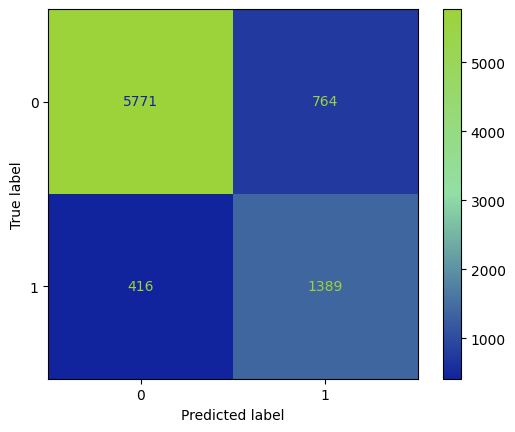

In [47]:
ConfusionMatrixDisplay.from_estimator(arvore, x_teste, alvo_teste, cmap = mapa_calor)
plt.grid(False)
plt.show()

#### GradientBoostingClassifier

In [48]:
gboost = GradientBoostingClassifier(random_state=SEED)
gboost.fit(X_balanceado_over, alvo_balanceado_over)
previsao_gboost = gboost.predict(x_teste)

In [49]:
print(classification_report(alvo_teste, previsao_gboost))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      6535
           1       0.77      0.73      0.75      1805

    accuracy                           0.90      8340
   macro avg       0.85      0.84      0.84      8340
weighted avg       0.89      0.90      0.89      8340



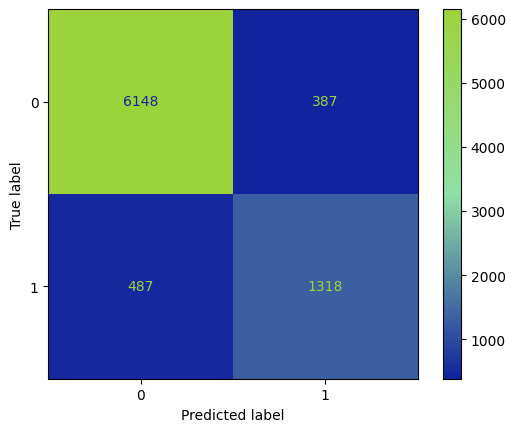

In [50]:
ConfusionMatrixDisplay.from_estimator(gboost, x_teste, alvo_teste, cmap = mapa_calor)
plt.grid(False)
plt.show()

#### LogisticRegression

In [51]:
reg_logistica = LogisticRegression(random_state=SEED, max_iter =1000)
reg_logistica.fit(X_balanceado_over, alvo_balanceado_over)
previsao_reglog = reg_logistica.predict(x_teste)

In [52]:
print(classification_report(alvo_teste, previsao_reglog))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87      6535
           1       0.54      0.76      0.63      1805

    accuracy                           0.81      8340
   macro avg       0.73      0.79      0.75      8340
weighted avg       0.84      0.81      0.82      8340



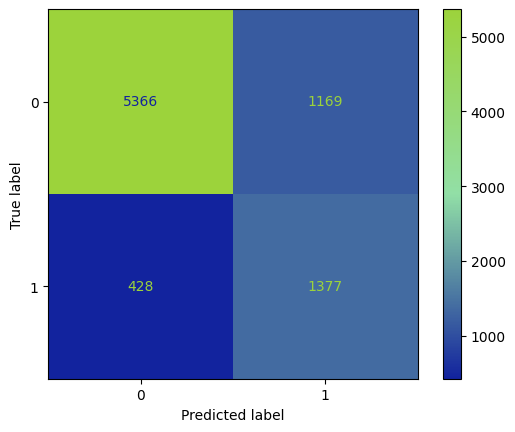

In [53]:
ConfusionMatrixDisplay.from_estimator(reg_logistica, x_teste, alvo_teste, cmap = mapa_calor)
plt.grid(False)
plt.show()

Salvando resultados dos modelos utilizando a técnica de oversampling para posterior comparação com a técnica de undersampling:

In [54]:
from sklearn.metrics import recall_score
metricas_over = pd.DataFrame({'Acurácia treino':[arvore.score(x_treino, alvo_treino), 
                                 gboost.score(x_treino, alvo_treino), 
                                 reg_logistica.score(x_treino, alvo_treino)], 
            'Acurácia teste': [arvore.score(x_teste, alvo_teste), 
                                 gboost.score(x_teste, alvo_teste), 
                                 reg_logistica.score(x_teste, alvo_teste)], 
            'Recall':[recall_score(alvo_teste, previsao_arvore),
                      recall_score(alvo_teste, previsao_gboost),
                      recall_score(alvo_teste, previsao_reglog)]},
             index = ['Árvore de Decisão Oversampling', 'Gradient Boosting Oversampling', 'Regressão Logísitica Oversampling'])

### Aprendizado Undersampling

Agora será realizado o balanceamento da variável alvo utilizando a técnica de undersampling, que removerá aleatoriamente registros da classe mais frequente, igualando a quantidade de registros das duas classes.

In [55]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(random_state=SEED,sampling_strategy=0.5)
X_balanceado_under, alvo_balanceado_under = under.fit_resample(x_treino, alvo_treino)
X_balanceado_under

,onehotencoder__situacao_moradia_Mortgage,onehotencoder__situacao_moradia_Other,onehotencoder__situacao_moradia_Own,onehotencoder__situacao_moradia_Rent,onehotencoder__motivo_emprestimo_Debtconsolidation,onehotencoder__motivo_emprestimo_Education,onehotencoder__motivo_emprestimo_Homeimprovement,onehotencoder__motivo_emprestimo_Medical,onehotencoder__motivo_emprestimo_Personal,onehotencoder__motivo_emprestimo_Venture,...,onehotencoder__pontuacao_emprestimo_F,onehotencoder__pontuacao_emprestimo_G,remainder__idade,remainder__salario,remainder__tempo_trabalho,remainder__valor_emprestimo,remainder__taxa_juros,remainder__renda_percentual_emprestimo,remainder__devendo,remainder__tempo_de_credito
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.234043,0.028874,0.146341,0.271429,0.291128,0.192771,0.0,0.035714
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.319149,0.013727,0.341463,0.411429,0.524548,0.614458,0.0,0.107143
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.244681,0.030395,0.048780,0.142857,0.233419,0.096386,0.0,0.035714
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.276596,0.014025,0.048780,0.200000,0.298019,0.289157,0.0,0.035714
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.244681,0.058830,0.170732,0.140000,0.307494,0.048193,0.0,0.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16240,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.425532,0.265028,0.195122,1.000000,0.688630,0.072289,1.0,0.321429
16241,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.223404,0.016668,0.121951,0.034286,0.546512,0.048193,0.0,0.071429
16242,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.265957,0.025419,0.048780,0.102857,0.602498,0.072289,0.0,0.000000
16243,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.276596,0.016668,0.121951,0.285714,0.564599,0.349398,1.0,0.035714


#### DecisionTreeClassifier

In [56]:
arvore = DecisionTreeClassifier(random_state=SEED)
arvore.fit(X_balanceado_under, alvo_balanceado_under)
previsao_arvore = arvore.predict(x_teste)

In [57]:
print(classification_report(alvo_teste, previsao_arvore))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      6535
           1       0.63      0.78      0.70      1805

    accuracy                           0.85      8340
   macro avg       0.78      0.83      0.80      8340
weighted avg       0.87      0.85      0.86      8340



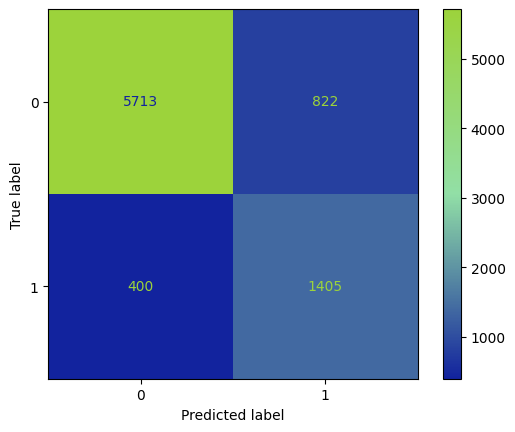

In [58]:
ConfusionMatrixDisplay.from_estimator(arvore, x_teste, alvo_teste, cmap = mapa_calor)
plt.grid(False)
plt.show()

#### GradientBoostingClassifier

In [59]:
gboost = GradientBoostingClassifier(random_state=SEED)
gboost.fit(X_balanceado_under, alvo_balanceado_under)
previsao_gboost = gboost.predict(x_teste)

In [60]:
print(classification_report(alvo_teste, previsao_gboost))

              precision    recall  f1-score   support

           0       0.93      0.97      0.94      6535
           1       0.85      0.72      0.78      1805

    accuracy                           0.91      8340
   macro avg       0.89      0.84      0.86      8340
weighted avg       0.91      0.91      0.91      8340



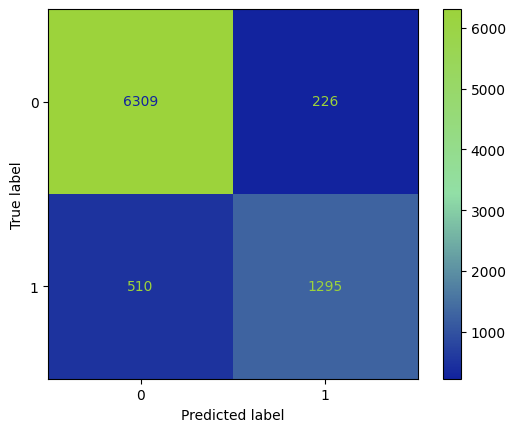

In [61]:
ConfusionMatrixDisplay.from_estimator(gboost, x_teste, alvo_teste, cmap = mapa_calor)
plt.grid(False)
plt.show()

#### LogisticRegression

In [62]:
reg_logistica = LogisticRegression(random_state=SEED, max_iter =1000)
reg_logistica.fit(X_balanceado_under, alvo_balanceado_under)
previsao_reglog = reg_logistica.predict(x_teste)

In [63]:
print(classification_report(alvo_teste, previsao_reglog))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      6535
           1       0.67      0.65      0.66      1805

    accuracy                           0.86      8340
   macro avg       0.79      0.78      0.79      8340
weighted avg       0.85      0.86      0.86      8340



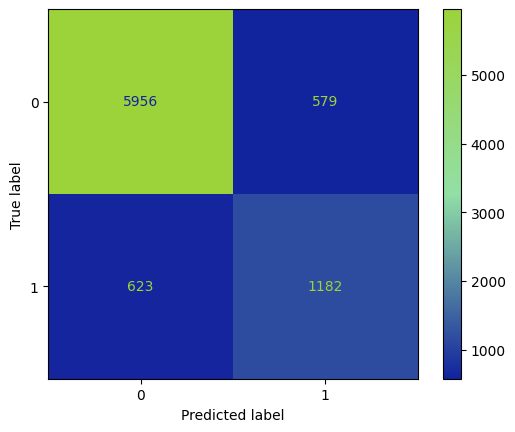

In [64]:
ConfusionMatrixDisplay.from_estimator(reg_logistica, x_teste, alvo_teste, cmap = mapa_calor)
plt.grid(False)
plt.show()

Salvando os resultados dos modelos utilizando a técnica de undersampling para posterior comparação com a técnica de oversampling:

In [65]:
metricas_under = pd.DataFrame({'Acurácia treino':[arvore.score(x_treino, alvo_treino), 
                                 gboost.score(x_treino, alvo_treino), 
                                 reg_logistica.score(x_treino, alvo_treino)], 
            'Acurácia teste': [arvore.score(x_teste, alvo_teste), 
                                 gboost.score(x_teste, alvo_teste), 
                                 reg_logistica.score(x_teste, alvo_teste)], 
            'Recall':[recall_score(alvo_teste, previsao_arvore),
                      recall_score(alvo_teste, previsao_gboost),
                      recall_score(alvo_teste, previsao_reglog)]},
             index = ['Árvore de Decisão Undersampling', 'Gradient Boosting Undersampling', 'Regressão Logísitica Undersampling'])

### Comparando samplings

In [66]:
display(metricas_over,metricas_under)

,Acurácia treino,Acurácia teste,Recall
Árvore de Decisão Oversampling,1.000000,0.858513,0.769529
Gradient Boosting Oversampling,0.900867,0.895204,0.730194
Regressão Logísitica Oversampling,0.805652,0.808513,0.762881


,Acurácia treino,Acurácia teste,Recall
Árvore de Decisão Undersampling,0.953911,0.853477,0.778393
Gradient Boosting Undersampling,0.915058,0.911751,0.717452
Regressão Logísitica Undersampling,0.858656,0.855875,0.654848


Analisando as tabelas, foi possível tirar as seguintes conclusões:

* A regressão logística apresenta um baixo desempenho em relação aos demais modelos.
* A árvore de decisão apresenta overfitting no oversampling.
* O gradient boosting foi o modelo mais consistente, não apresentando overfiting.

Vamos analisar as matrizes de confusão do Gradient Boosting usando as técnicas de oversampling e undersampling:



- Oversampling - gradientBoosting

![](https://i.imgur.com/IxO41mh.png)

- Undersampling - gradientBoosting

![](https://i.imgur.com/Hkv2mGj.png)

É possível identificar que o modelo de gradient boosting usando técnica undersampling possui um resultado geral melhor, com menos erros do que o modelo que usa a técnica de oversampling.

Apesar de o recall do modelo que usa o oversampling ser melhor, ocasiona em um erro muito maior para os clientes não inadimplentes em relação ao modelo que usa o undersampling, o que pode gerar uma insatisfação muito grande nos clientes e perder grande parte do potencial de lucro da empresa.

**Escolha**:

**O modelo escolhido foi o Gradient Boosting usando a técnica de undersampling.**

## Otimização de hiperparâmetros

Vamos passar agora para a otimização de hiperparâmetros do modelo selecionado com o GridSearch.

In [67]:
from sklearn.model_selection import GridSearchCV
import numpy as np

Parâmetros a serem testados:

In [68]:
parameters = {
    "loss":["deviance"],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "absolute_error"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9],
    "n_estimators":[10,100]
    }


In [69]:
grid_search = GridSearchCV(GradientBoostingClassifier(random_state = SEED), parameters,scoring='recall',cv=3,verbose = 1)

grid_search.fit(X_balanceado_under, alvo_balanceado_under)

Fitting 3 folds for each of 120 candidates, totalling 360 fits


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  war

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=144),
             param_grid={'criterion': ['friedman_mse', 'absolute_error'],
                         'loss': ['deviance'], 'max_depth': [3, 5, 8],
                         'max_features': ['log2', 'sqrt'],
                         'n_estimators': [10, 100],
                         'subsample': [0.5, 0.618, 0.8, 0.85, 0.9]},
             scoring='recall', verbose=1)

In [70]:
grid_search.cv_results_

{'mean_fit_time': array([6.96288745e-02, 7.35425949e-02, 6.62128925e-02, 6.88988368e-02,
        6.80110455e-02, 5.61418136e-01, 5.93729734e-01, 5.88431120e-01,
        5.75179577e-01, 7.00621923e-01, 9.33253765e-02, 9.71570810e-02,
        1.01060788e-01, 1.01062059e-01, 1.14050150e-01, 5.82562049e-01,
        6.01650635e-01, 6.22946819e-01, 6.20793263e-01, 6.31327391e-01,
        8.37060610e-02, 8.67214203e-02, 1.16380215e-01, 1.36806170e-01,
        1.37875398e-01, 9.41594283e-01, 9.47804689e-01, 8.27648799e-01,
        8.28157743e-01, 1.57456342e+00, 8.60329469e-02, 8.88299147e-02,
        9.48882103e-02, 9.55468814e-02, 1.01101478e-01, 7.73654064e-01,
        8.35529884e-01, 8.96085501e-01, 1.22291676e+00, 9.24698591e-01,
        1.52188063e-01, 1.62354946e-01, 1.67311430e-01, 1.70975447e-01,
        1.73615694e-01, 1.44465534e+00, 1.70277135e+00, 1.56362534e+00,
        1.93300438e+00, 1.61404220e+00, 1.50414308e-01, 1.69421911e-01,
        1.77054564e-01, 1.85594718e-01, 1.91641

In [71]:
previsao_grid_search = grid_search.best_estimator_
previsao_grid = previsao_grid_search.predict(x_teste)

Retornando o melhor estimador encontrado pelo Grid Search:

In [72]:
grid_search.best_estimator_

GradientBoostingClassifier(loss='deviance', max_depth=8, max_features='sqrt',
                           random_state=144, subsample=0.5)

In [73]:
print(classification_report(alvo_teste, previsao_grid))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6535
           1       0.88      0.75      0.81      1805

    accuracy                           0.92      8340
   macro avg       0.91      0.86      0.88      8340
weighted avg       0.92      0.92      0.92      8340



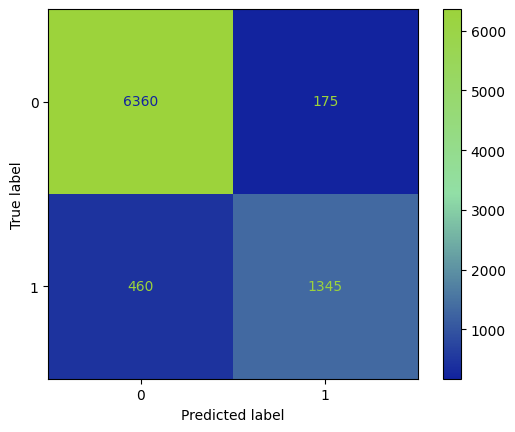

In [74]:
ConfusionMatrixDisplay.from_estimator(previsao_grid_search, x_teste, alvo_teste, cmap = mapa_calor)
plt.grid(False)
plt.show()

Através do resultado, podemos verificar que o desempenho aumentou, principalmente entre os clientes não inadimplentes e esse será o modelo que será colocado em produção.

## Resumo

> Importamos os dataset criado no Microsoft SQL Server e iniciamos uma análise focada no tratamento de dados para serem inseridos em um modelo de ML. Desse modo, removemos valores nulos e outliers presentes nos dados, bem como aplicamos o balanceamento, normalização e enconding para tratar o conjunto de dados.

> Assim, construimos três modelos de aprendizado de máquina pensando na explicabilidade do resultado final, comparamos o desempenho deles para o projeto e escolhemos o que teve melhor performance. Com isso, buscamos melhorar ainda mais o resultado final do modelo com uma otimização de hiperparâmetros e, assim que obtivemos um bom produto final, salvamos o modelo fazendo sua exportação.

## Exportando modelos

Iremos exportar os modelos para que possam ser utilizados futuramente fora do ambiente do Google Colaboratory

In [75]:
import pickle

Modelo one hot encoder:

In [76]:
with open('one_hot_encoder.pkl', 'wb') as file:
    pickle.dump(one_hot_enc, file)

Modelo de normalização dos dados:

In [77]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

Modelo do gradient boosting do grid search:

In [78]:
with open('modelo_treinado.pkl', 'wb') as file:
    pickle.dump(previsao_grid_search, file)